Epoch 0, Loss: 1.167685
Epoch 1, Loss: 1.134813
Epoch 2, Loss: 1.122011
Epoch 3, Loss: 1.099009
Epoch 4, Loss: 1.075732
Epoch 5, Loss: 1.058795
Epoch 6, Loss: 1.045803
Epoch 7, Loss: 1.032087
Epoch 8, Loss: 1.016991
Epoch 9, Loss: 1.002607
Epoch 10, Loss: 0.990484
Epoch 11, Loss: 0.980066
Epoch 12, Loss: 0.969767
Epoch 13, Loss: 0.958732
Epoch 14, Loss: 0.947425
Epoch 15, Loss: 0.936724
Epoch 16, Loss: 0.926892
Epoch 17, Loss: 0.917317
Epoch 18, Loss: 0.907262
Epoch 19, Loss: 0.896584
Epoch 20, Loss: 0.885665
Epoch 21, Loss: 0.875111
Epoch 22, Loss: 0.864806
Epoch 23, Loss: 0.854323
Epoch 24, Loss: 0.843219
Epoch 25, Loss: 0.831648
Epoch 26, Loss: 0.819983
Epoch 27, Loss: 0.808296
Epoch 28, Loss: 0.796213
Epoch 29, Loss: 0.783526
Epoch 30, Loss: 0.770454
Epoch 31, Loss: 0.757232
Epoch 32, Loss: 0.743917
Epoch 33, Loss: 0.730191
Epoch 34, Loss: 0.716010
Epoch 35, Loss: 0.701657
Epoch 36, Loss: 0.687265
Epoch 37, Loss: 0.672790
Epoch 38, Loss: 0.658204
Epoch 39, Loss: 0.643883
Epoch 40, 

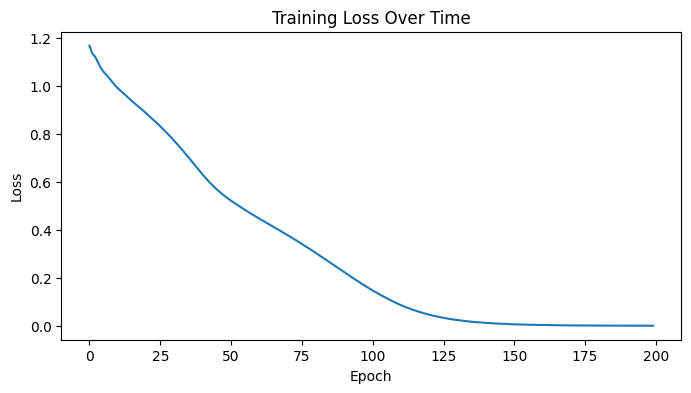

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ======= Generate Training Data =======
# Parameters
n = 64  # Input function length
m = 64  # Output Fourier transform length

# Generate a more complex function: Sum of sines and cosines
x = np.linspace(0, 10, n)
signal = (
    0.5 * np.sin(2 * np.pi * x) +
    0.3 * np.sin(4 * np.pi * x) +
    0.2 * np.sin(6 * np.pi * x) +
    0.5 * np.cos(2 * np.pi * x) +
    0.3 * np.cos(4 * np.pi * x)
)

# Normalize signal
signal_mean, signal_std = np.mean(signal), np.std(signal)
#signal_mean, signal_std = 0, 1
signal_norm = (signal - signal_mean) / signal_std  # Normalize input signal

# Compute the Fourier Transform (Full Complex FFT)
fft_signal = np.fft.fft(signal_norm)  # Get full complex values
fft_magnitude = np.abs(fft_signal)[:m]  # Take only first m components
fft_phase = np.angle(fft_signal)[:m]  # Get phase of the FFT components

# 🔥 Store mean and std for denormalization later
fft_mean, fft_std = np.mean(fft_magnitude), np.std(fft_magnitude)
#fft_mean, fft_std = 0, 1

# Normalize output
fft_magnitude_norm = (fft_magnitude - fft_mean) / fft_std  # Normalize FFT magnitude

# Convert to PyTorch tensors
X_train = torch.tensor(signal_norm, dtype=torch.float32).unsqueeze(1)  # Shape: (n, 1)
Y_train = torch.tensor(fft_magnitude_norm, dtype=torch.float32).unsqueeze(1)  # Shape: (m, 1)


# ======= Positional Encoding =======
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

# ======= Custom Attention Block with Explicit Q, K, V =======
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        
        self.W_q = nn.Linear(d_model, d_model)  # Query projection
        self.W_k = nn.Linear(d_model, d_model)  # Key projection
        self.W_v = nn.Linear(d_model, d_model)  # Value projection
        self.W_o = nn.Linear(d_model, d_model)  # Output projection
    
    def forward(self, x):
        batch_size, seq_length, d_model = x.shape

        # Compute Q, K, V
        Q = self.W_q(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)  # (batch, heads, seq_len, d_k)
        K = self.W_k(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)  # (batch, heads, seq_len, seq_len)
        attn_weights = torch.softmax(scores, dim=-1)

        # Apply attention to values
        attended_values = torch.matmul(attn_weights, V)  # (batch, heads, seq_len, d_k)

        # Reshape and apply final projection
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, seq_length, d_model)
        return self.W_o(attended_values)

# ======= Transformer Encoder Block =======
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

# ======= Transformer Model =======
class FourierTransformer(nn.Module):
    def __init__(self, d_model=64, num_heads=4, num_layers=4):
        super().__init__()

        self.input_proj = nn.Linear(1, d_model)  # Convert 1D input to d_model
        self.positional_encoding = PositionalEncoding(d_model)

        self.encoder_layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads) for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads) for _ in range(num_layers)
        ])

        self.output_proj = nn.Linear(d_model, 1)  # Convert back to 1D

    def forward(self, src, tgt):
        src = self.input_proj(src)  # Shape: (batch, seq_len, d_model)
        src = self.positional_encoding(src)

        tgt = self.input_proj(tgt)  # Shape: (batch, seq_len, d_model)
        tgt = self.positional_encoding(tgt)

        # Encoder pass
        for layer in self.encoder_layers:
            src = layer(src)

        # Decoder pass
        for layer in self.decoder_layers:
            tgt = layer(tgt)

        return self.output_proj(tgt)  # Output (batch, seq_len, 1)

# ======= Initialize Model & Optimizer =======
model = FourierTransformer(d_model=64, num_heads=4, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# ======= Training Loop (Auto-Regressive Learning with Updates at Each Step) =======
epochs = 200
loss_history = []

for epoch in range(epochs):
    src = X_train.unsqueeze(0)  # Shape: (1, n, 1)
    tgt = torch.zeros(1, m, 1)  # Start with all zeros

    optimizer.zero_grad()
    pred = model(src, tgt)
    loss = loss_fn(pred, Y_train.unsqueeze(0))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ======= Plot Loss Curve =======
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


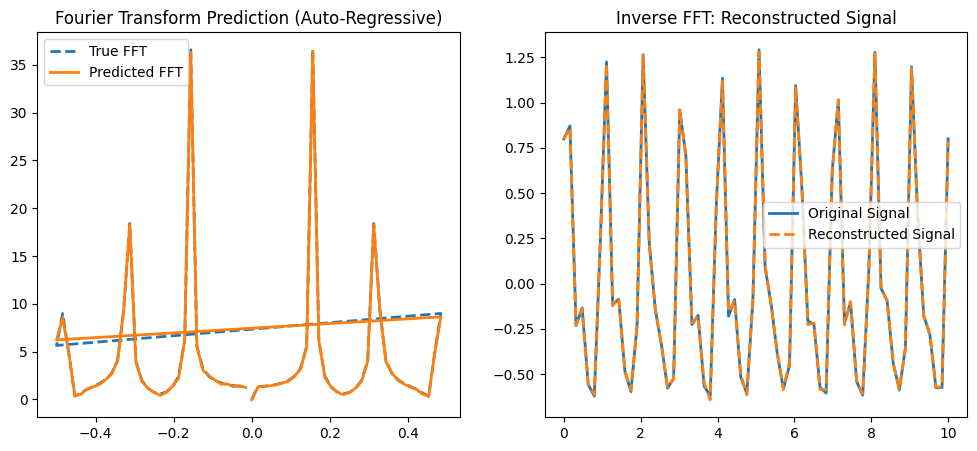

In [2]:
# ======= Evaluate Model on Training Data =======
with torch.no_grad():
    src = X_train.unsqueeze(0)  # Shape: (1, n, 1)
    tgt = torch.zeros(1, m, 1)  # Start with a single zero in decoder input

    predicted_fft_norm = model(src, tgt).squeeze(0).numpy()  # Predict normalized FFT

# 🔥 Denormalize Predicted FFT Magnitude
predicted_fft_mag = (predicted_fft_norm * fft_std) + fft_mean  # Restore magnitude scale
predicted_fft_mag = predicted_fft_mag.squeeze()  # ✅ Flatten to 1D

# 🔥 Reconstruct Complex FFT using Phase
predicted_fft_full = np.zeros(n, dtype=complex)  # Full FFT spectrum
predicted_fft_full[:m] = predicted_fft_mag * np.exp(1j * fft_phase)  # ✅ Correctly applied phase
predicted_fft_full[-m+1:] = np.flip(np.conj(predicted_fft_full[1:m]))  # Mirror for real IFFT

# 🔥 Apply Inverse FFT (IFFT) to Recover Original Signal
reconstructed_signal = np.fft.ifft(predicted_fft_full).real  # Take real part

# ❌🔥 DO NOT Multiply by `n` - IFFT already scales correctly!

# 🔥 Denormalize Reconstructed Signal Properly
reconstructed_signal = (reconstructed_signal * signal_std) + signal_mean  # Restore scale

# ======= Plot Predictions =======
plt.figure(figsize=(12, 5))

# 🔹 Plot Original vs. Predicted Fourier Transform
plt.subplot(1, 2, 1)
plt.plot(np.fft.fftfreq(n)[:m], fft_magnitude, label="True FFT", linestyle="dashed", linewidth=2)
plt.plot(np.fft.fftfreq(n)[:m], predicted_fft_mag, label="Predicted FFT", linewidth=2)
plt.legend()
plt.title("Fourier Transform Prediction (Auto-Regressive)")

# 🔹 Plot Original vs. Reconstructed Signal
plt.subplot(1, 2, 2)
plt.plot(x, signal, label="Original Signal", linewidth=2)
plt.plot(x, reconstructed_signal, label="Reconstructed Signal", linestyle="dashed", linewidth=2)
plt.legend()
plt.title("Inverse FFT: Reconstructed Signal")

plt.show()


# Next solve an Integral Equation

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ======= Define the Integral Equation =======
# We use a simple kernel: K(x, y) = exp(-|x - y|)

def kernel(x, y):
    #return np.exp(-np.abs(x - y))
    return 1/(0.0001+0.0000001*np.sqrt(np.abs(x - y)))

# Discretization
n = 64  # Number of x points
m = 64  # Number of y points
x = np.linspace(0, 10, n)
y = np.linspace(0, 10, m)
dx = y[1] - y[0]  # Step size for integration

# Create the Kernel Matrix
K_matrix = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        K_matrix[i, j] = kernel(x[i], y[j])

# Define a true solution u(y) for testing
u_true = np.sin(y)*np.cos(y)  # Some function we want to recover

# Compute the integral to get f(x)
f_x = np.dot(K_matrix, u_true) * dx  # Approximate integral using summation

# 🔥 Store mean and std for normalization
f_mean, f_std = np.mean(f_x), np.std(f_x)
u_mean, u_std = np.mean(u_true), np.std(u_true)

# Normalize input and output
f_x_norm = (f_x - f_mean) / f_std
u_true_norm = (u_true - u_mean) / u_std

# Convert to PyTorch tensors
X_train = torch.tensor(f_x_norm, dtype=torch.float32).unsqueeze(1)  # (n, 1)
Y_train = torch.tensor(u_true_norm, dtype=torch.float32).unsqueeze(1)  # (m, 1)

# ======= Initialize Model & Optimizer (Your Transformer) =======
model = FourierTransformer(d_model=64, num_heads=4, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# ======= Training Loop =======
epochs = 200
loss_history = []

for epoch in range(epochs):
    src = X_train.unsqueeze(0)  # Shape: (1, n, 1)
    tgt = torch.zeros(1, m, 1)  # Start with all zeros

    optimizer.zero_grad()
    pred = model(src, tgt)
    loss = loss_fn(pred, Y_train.unsqueeze(0))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")



Epoch 0, Loss: 1.174004
Epoch 20, Loss: 0.577947
Epoch 40, Loss: 0.041380
Epoch 60, Loss: 0.004706
Epoch 80, Loss: 0.000757
Epoch 100, Loss: 0.000202
Epoch 120, Loss: 0.000075
Epoch 140, Loss: 0.000039
Epoch 160, Loss: 0.000022
Epoch 180, Loss: 0.000013


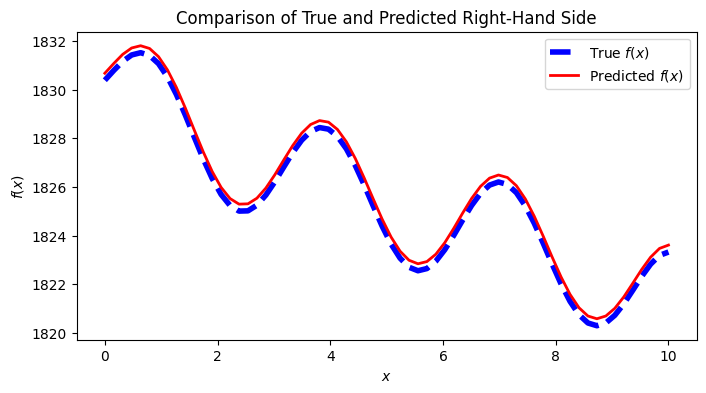

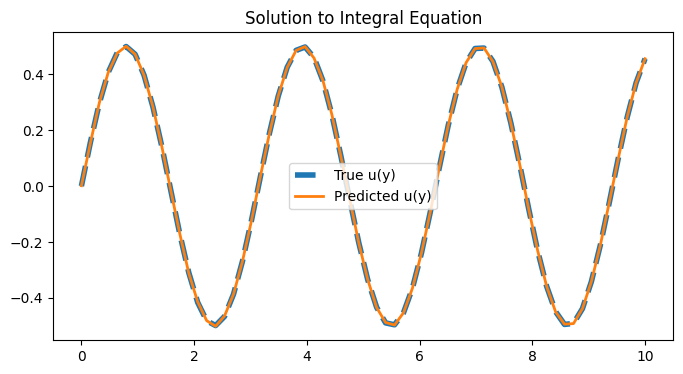

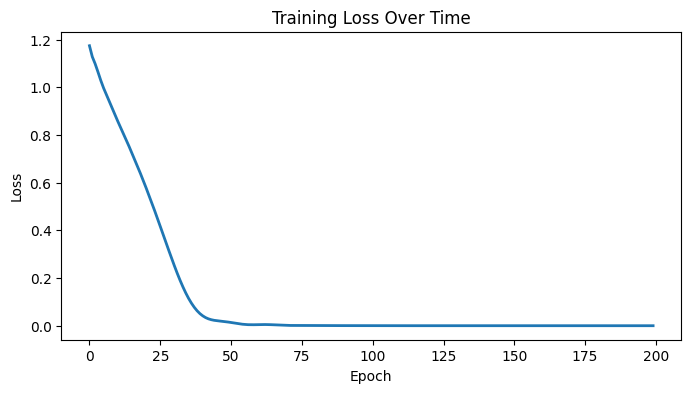

In [4]:
# ======= Evaluate Model on Training Data =======
with torch.no_grad():
    src = X_train.unsqueeze(0)  # Shape: (1, n, 1)
    tgt = torch.zeros(1, m, 1)  # Start with zeros

    predicted_u_norm = model(src, tgt).squeeze(0).numpy()  # Predict unknown function

# 🔥 Denormalize Predicted Solution
predicted_u = (predicted_u_norm * u_std) + u_mean

# ======= Compute Right-Hand Side from Transformer Solution =======
f_x_pred = np.dot(K_matrix, predicted_u) * dx  # Use the learned u(y)

# ======= Plot the Right-Hand Side Comparison =======
plt.figure(figsize=(8, 4))
plt.plot(x, f_x, label="True $f(x)$", linewidth=4, linestyle="dashed", color="blue")
plt.plot(x, f_x_pred, label="Predicted $f(x)$", linewidth=2, color="red")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Comparison of True and Predicted Right-Hand Side")
plt.legend()
plt.show()

# ======= Plot Results =======

# 🔹 Plot Original vs. Predicted Solution u(y)
plt.figure(figsize=(8, 4))
plt.plot(y, u_true, label="True u(y)", linestyle="dashed", linewidth=4)
plt.plot(y, predicted_u, label="Predicted u(y)", linewidth=2)
plt.legend()
plt.title("Solution to Integral Equation")
plt.show()

# 🔹 Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")

plt.show()


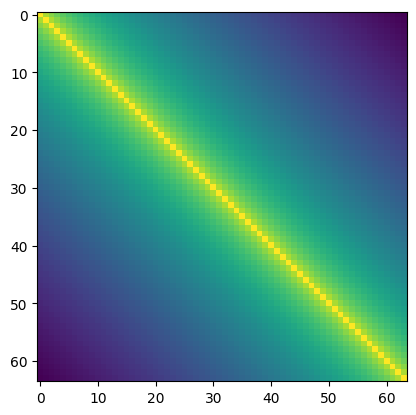

In [5]:
plt.imshow(K_matrix)